In [2]:
import tensorflow as tf
from tensorflow import keras
print("num GPUs available:" , len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "



num GPUs available: 0


False

In [1]:
# importing required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score
import seaborn as sns
from shutil import copy
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import random
import os
import cv2

from tensorflow.keras.callbacks import TensorBoard
import datetime

np.random.seed(42) 
# Direction for data folder
DATA_DIR = 'data'

In [2]:
def load_data(DATA_DIR=DATA_DIR, test_size=0.2, verbose=True, load_grayscale=True):
    print(os.getcwd())
    """
        Loads the data into a dataframe.
        
        Arguments:
            DATA_DIR: str
            test_size: float
        Returns:
            (x_train, y_train,x_test, y_test, x_val, y_val, df)
    """
    features = []
    features_forged = []
    features_real = []
    features_dict = {}
    labels = [] # forged: 0 and real: 1
    mode = "rgb"
    if load_grayscale:
        mode = "grayscale"
    for folder in os.listdir(DATA_DIR):
        # forged images
        if folder == '.DS_Store' or folder == '.ipynb_checkpoints':
            continue
        print ("Searching folder {}".format(folder))
        print(folder)
        for sub in os.listdir(DATA_DIR+"/"+folder+"/forge"):
            f = DATA_DIR+"/"+folder+"/forge/" + sub
            img = load_img(f,color_mode=mode, target_size=(150,150))
            features.append(img_to_array(img))
            features_dict[sub] = (img, 0)
            features_forged.append(img)
            if verbose:
                print ("Adding {} with label 0".format(f))
            labels.append(0) # forged
        # real images
        for sub in os.listdir(DATA_DIR+"/"+folder+"/real"):
            f = DATA_DIR+"/"+folder+"/real/" + sub
            img = load_img(f,color_mode=mode, target_size=(150,150))
            features.append(img_to_array(img))
            features_dict[sub] = (img, 1)
            features_real.append(img)
            if verbose:
                print ("Adding {} with label 1".format(f))
            labels.append(1) # real
            
    features = np.array(features)
    labels = np.array(labels)
    
    x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, random_state=42)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)
    
    print ("Generated data.")
    return features, labels,features_forged, features_real,features_dict,x_train, x_test, y_train, y_test, x_val, y_val


def convert_label_to_text(label=0):
    """
        Convert label into text
        
        Arguments:
            label: int
        Returns:
            str: The mapping
    """
    return "Forged" if label == 0 else "Real"

In [3]:
features, labels,features_forged, features_real, features_dict,x_train, x_test, y_train, y_test, x_val, y_val = load_data(verbose=False, load_grayscale=False) 

C:\Users\Shivani\project
Searching folder Dataset_Signature_Final
Dataset_Signature_Final
Searching folder sample_Signature
sample_Signature
Generated data.


visulazion

Distribution: [210 210]


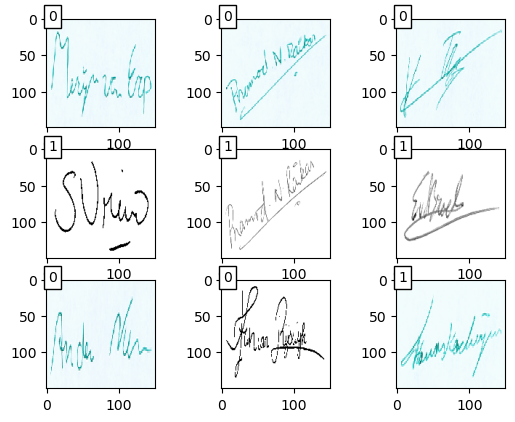

In [4]:
f, axarr = plt.subplots(3,3)
axarr[0,0].imshow(features[0]/255.)
axarr[0,0].text(2, 2, labels[0], bbox={'facecolor': 'white', 'pad': 3})
axarr[0,1].imshow(features[1]/255.)
axarr[0,1].text(2, 2, labels[1], bbox={'facecolor': 'white', 'pad': 3})
axarr[0,2].imshow(features[2]/255.)
axarr[0,2].text(2, 2, labels[2], bbox={'facecolor': 'white', 'pad': 3})
axarr[1,0].imshow(features[300]/255.)
axarr[1,0].text(2, 2, labels[300], bbox={'facecolor': 'white', 'pad': 3})
axarr[1,1].imshow(features[400]/255.)
axarr[1,1].text(2, 2, labels[400], bbox={'facecolor': 'white', 'pad': 3})
axarr[1,2].imshow(features[410]/255.)
axarr[1,2].text(2, 2, labels[410], bbox={'facecolor': 'white', 'pad': 3})
axarr[2,0].imshow(features[6]/255.)
axarr[2,0].text(2, 2, labels[6], bbox={'facecolor': 'white', 'pad': 3})
axarr[2,1].imshow(features[200]/255.)
axarr[2,1].text(2, 2, labels[200], bbox={'facecolor': 'white', 'pad': 3})
axarr[2,2].imshow(features[100]/255.)
axarr[2,2].text(2, 2, labels[100], bbox={'facecolor': 'white', 'pad': 3})

print ("Distribution: {}".format(np.bincount(labels)))

Similarity in images (signatures) using MSE and SSIM

In [5]:
def mse(A, B):
    """
        Computes Mean Squared Error between two images. (A and B)
        
        Arguments:
            A: numpy array
            B: numpy array
        Returns:
            err: float
    """
    
    # sigma(1, n-1)(a-b)^2)
    err = np.sum((A - B) ** 2)
    
    # mean of the sum (r,c) => total elements: r*c
    err /= float(A.shape[0] * B.shape[1])
    
    return err


def ssim(A, B):
    """
        Computes SSIM between two images.
        
        Arguments:
            A: numpy array
            B: numpy array
            
        Returns:
            score: float
    """
    
    return structural_similarity(A, B)

Here we take two images from the same person, one of them is real and the other is a fake.

In [6]:
A = features_dict["02100002.png"] # 2 by 2 [forge]
B = features_dict["00200002.png"] # 2 by 2 [real]

Signature: Forged


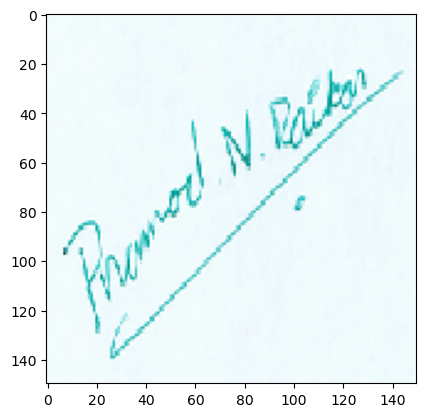

In [7]:
print ("Signature: {}".format(convert_label_to_text(A[1])))
plt.imshow(A[0])

Signature: Real


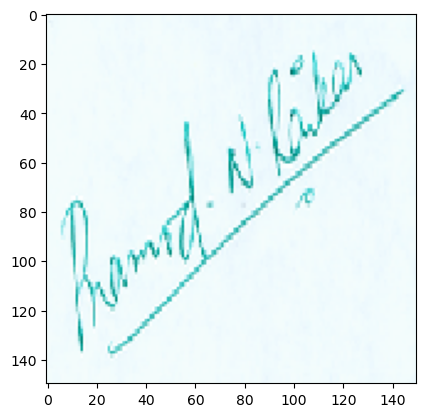

In [8]:
print ("Signature: {}".format(convert_label_to_text(B[1])))
plt.imshow(B[0])

In [9]:
A_array = img_to_array(A[0])
B_array = img_to_array(B[0])
print ("MSE Error: {}".format(mse(A_array, B_array)))
print("SSIM: {}".format(ssim(A_array.flatten(),B_array.flatten())))

MSE Error: 2780.9489777777776


ValueError: Since image dtype is floating point, you must specify the data_range parameter. Please read the documentation carefully (including the note). It is recommended that you always specify the data_range anyway.

Building a classifier using CNNs that can detect forged or real signatures.

In [10]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(64, (3,3), input_shape=(150,150,3), activation='relu'))
model.add(tf.keras.layers.MaxPool2D(2))
model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPool2D(2))
model.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPool2D(2))
model.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy, metrics=['acc'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 16)        0

In [12]:
# normalize inputs
x_train /= 255.
x_val /= 255.
x_test /= 255.

In [13]:
history = model.fit(x_train, y_train, epochs=5, validation_data=(x_val, y_val))

Epoch 1/5


8/8 [==============================] - 4s 273ms/step - loss: 0.7260 - acc: 0.5278 - val_loss: 0.7072 - val_acc: 0.5000
Epoch 2/5
8/8 [==============================] - 2s 221ms/step - loss: 0.6908 - acc: 0.5198 - val_loss: 0.6903 - val_acc: 0.5000
Epoch 3/5
8/8 [==============================] - 2s 233ms/step - loss: 0.6864 - acc: 0.5675 - val_loss: 0.6891 - val_acc: 0.5000
Epoch 4/5
8/8 [==============================] - 2s 223ms/step - loss: 0.6730 - acc: 0.6746 - val_loss: 0.6926 - val_acc: 0.5000
Epoch 5/5
8/8 [==============================] - 2s 204ms/step - loss: 0.6238 - acc: 0.6627 - val_loss: 0.7078 - val_acc: 0.5238


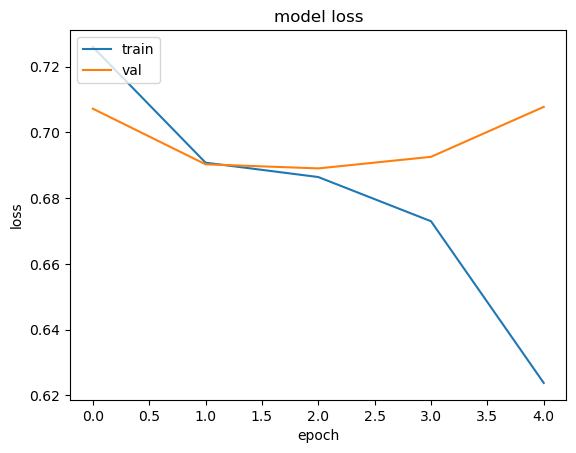

In [14]:
def plot_history(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

plot_history(history)

Transfer Learning using Inception.

In [15]:
# loading Inception
model2 = tf.keras.applications.InceptionV3(include_top=False, input_shape=(150,150,3))

In [16]:
# freezing layers
for layer in model2.layers:
    layer.trainable=False

In [17]:
# getting mixed7 layer
l = model2.get_layer("mixed7")

In [18]:
print ("mixed7 shape: {}".format(l.output_shape))

mixed7 shape: (None, 7, 7, 768)


In [19]:
x = tf.keras.layers.Flatten()(l.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(.5)(x)                  
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)           
net = tf.keras.Model(model2.input, x) 

In [20]:
net.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy, metrics=['acc'])

In [21]:
h2 = net.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=5)

Epoch 1/5
8/8 [==============================] - 9s 656ms/step - loss: 4.8179 - acc: 0.5357 - val_loss: 2.3698 - val_acc: 0.6190
Epoch 2/5
8/8 [==============================] - 4s 446ms/step - loss: 1.0904 - acc: 0.7381 - val_loss: 0.6867 - val_acc: 0.7262
Epoch 3/5
8/8 [==============================] - 3s 437ms/step - loss: 0.4461 - acc: 0.8294 - val_loss: 0.9482 - val_acc: 0.7262
Epoch 4/5
8/8 [==============================] - 3s 432ms/step - loss: 0.2964 - acc: 0.8849 - val_loss: 0.7350 - val_acc: 0.8333
Epoch 5/5
8/8 [==============================] - 3s 435ms/step - loss: 0.1396 - acc: 0.9484 - val_loss: 0.4202 - val_acc: 0.8452


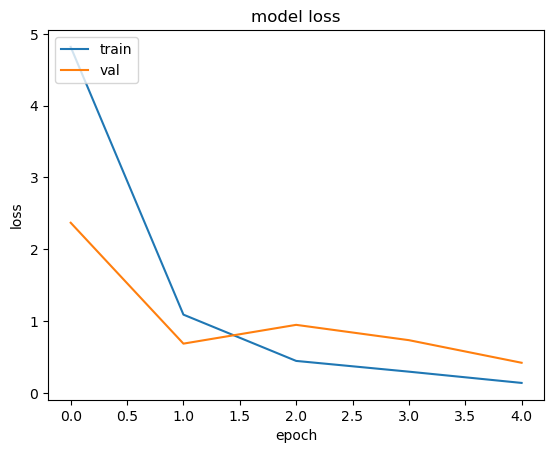

In [22]:
plot_history(h2)

In [23]:
preds = net.predict(x_test)
pred_labels = []

3/3 [==============================] - 2s 180ms/step


In [24]:
# threshold is 0.5
for p in preds:
    if p >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)
pred_labels = np.array(pred_labels)

In [25]:
print ("Accuracy on test set: {}".format(accuracy_score(y_test, pred_labels)))

Accuracy on test set: 0.8571428571428571


Siamese networks for image similarity

In [26]:
# the SNN is the diagram
feature_vector = tf.keras.Sequential()
feature_vector.add(tf.keras.layers.Conv2D(64,3, activation='relu', input_shape=(150,150,3)))
feature_vector.add(tf.keras.layers.BatchNormalization())
feature_vector.add(tf.keras.layers.Conv2D(32,3, activation='relu'))
feature_vector.add(tf.keras.layers.BatchNormalization())
feature_vector.add(tf.keras.layers.Conv2D(16, 3,activation='relu'))
feature_vector.add(tf.keras.layers.MaxPool2D((2,2)))
feature_vector.add(tf.keras.layers.Flatten())
feature_vector.add(tf.keras.layers.Dropout(0.2))
feature_vector.add(tf.keras.layers.Dense(512, activation='relu'))

In [27]:
feature_vector.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_98 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 batch_normalization_94 (Ba  (None, 148, 148, 64)      256       
 tchNormalization)                                               
                                                                 
 conv2d_99 (Conv2D)          (None, 146, 146, 32)      18464     
                                                                 
 batch_normalization_95 (Ba  (None, 146, 146, 32)      128       
 tchNormalization)                                               
                                                                 
 conv2d_100 (Conv2D)         (None, 144, 144, 16)      4624      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 72, 72, 16)       

In [28]:
# creating the siamese network
im_a = tf.keras.layers.Input(shape=(150,150,3))
im_b = tf.keras.layers.Input(shape=(150,150,3))

encoded_a = feature_vector(im_a)
encoded_b = feature_vector(im_b)

combined = tf.keras.layers.concatenate([encoded_a, encoded_b])
combine = tf.keras.layers.BatchNormalization()(combined)
combined = tf.keras.layers.Dense(4, activation = 'linear')(combined)
combined = tf.keras.layers.BatchNormalization()(combined)
combined = tf.keras.layers.Activation('relu')(combined)
combined = tf.keras.layers.Dense(1, activation = 'sigmoid')(combined)

sm = tf.keras.Model(inputs=[im_a, im_b], outputs=[combined])
sm.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 sequential_1 (Sequential)   (None, 512)                  4249310   ['input_2[0][0]',             
                                                          4          'input_3[0][0]']             
                                                                                                  
 concatenate_2 (Concatenate  (None, 1024)                 0         ['sequential_1[0][0]',  

In [29]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [30]:
sm.compile(optimizer=optimizer, loss = 'binary_crossentropy', metrics = ['mae'])

Another data generation approach1

In [31]:
def generate_data(person_number="001"):
    x = list(features_dict.keys())
    im_r = []
    im_f = []
    labels = [] # represents 1 if signature is real else 0
    for i in x:
        if i.startswith(person_number):
            if i.endswith("{}.png".format(person_number)):
                im_r.append(i)
                labels.append(1)
            else:
                im_f.append(i)
                labels.append(0)
    return im_r, im_f, labels


def generate_dataset_approach_two(size=100, test_size=0.25):
    """
        Generate data using the second approach.
        Remember input and output must be the same size!
        
        Arguments:
            features: numpy array
            labels: numpy array
            size: the target size (length of the array)
        Returns:
            x_train, y_train
    """
    im_r = []
    im_f = []
    ls = []

    ids = ["001","002","003",'004','005','006','007','008','009','010','011','012','013','014','015','016','017','018','019','020','021','022',
           '023','024','025','026','027','028','029','030']
    
    for i in ids:
        imr, imf, labels = generate_data(i)
        
        # similar batch
        for i in imr:
            for j in imr:
                im_r.append(img_to_array(features_dict[i][0]))
                im_f.append(img_to_array(features_dict[j][0]))
                ls.append(1) # they are similar
        
        # not similar batch
        for k in imf:
            for l in imf:
                im_r.append(img_to_array(features_dict[k][0]))
                im_f.append(img_to_array(features_dict[l][0]))
                ls.append(0) # they are not similar
    
    print(len(im_r), len(im_f))
    pairs = np.stack([im_r, im_f], axis=1)
    ls = np.array(ls)
    
    x_train, x_test, y_train, y_test = train_test_split(pairs, ls, test_size=test_size, random_state=42)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)
    return x_train, y_train, x_test, y_test, x_val, y_val, pairs, ls    
        

In [32]:
x_train, y_train, x_test, y_test, x_val, y_val, pairs, ls = generate_dataset_approach_two()


3900 3900


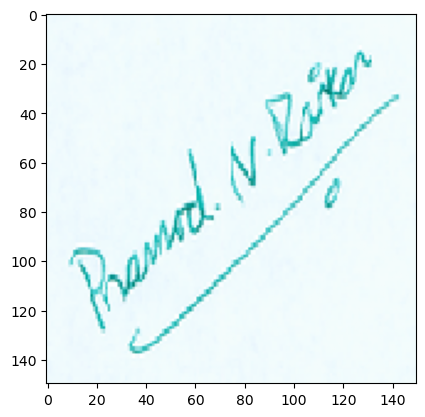

Label:  0


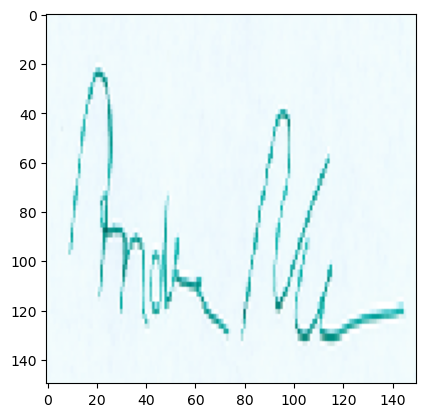

In [33]:
plt.imshow(x_train[:,0][0]/255.)
plt.show()
plt.imshow(x_train[:,0][1]/255.)
print("Label: ",y_train[0])

In [34]:
# Create a TensorBoard callback

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [35]:
h3= sm.fit([x_train[:,0], x_train[:,1]], y_train, epochs=50, validation_data=([x_test[:,0], x_test[:,1]], y_test),callbacks=[tensorboard_callback])


Epoch 1/50
69/69 [==============================] - 193s 3s/step - loss: 0.5089 - mae: 0.3886 - val_loss: 2.1214 - val_mae: 0.7792
Epoch 2/50
69/69 [==============================] - 148s 2s/step - loss: 0.3408 - mae: 0.2830 - val_loss: 5.0358 - val_mae: 0.9001
Epoch 3/50
69/69 [==============================] - 171s 2s/step - loss: 0.2513 - mae: 0.2195 - val_loss: 2.0079 - val_mae: 0.7909
Epoch 4/50
69/69 [==============================] - 148s 2s/step - loss: 0.2008 - mae: 0.1800 - val_loss: 0.1685 - val_mae: 0.1304
Epoch 5/50
69/69 [==============================] - 143s 2s/step - loss: 0.1538 - mae: 0.1412 - val_loss: 0.1917 - val_mae: 0.1728
Epoch 6/50
69/69 [==============================] - 146s 2s/step - loss: 0.1193 - mae: 0.1115 - val_loss: 0.1624 - val_mae: 0.1043
Epoch 7/50
69/69 [==============================] - 133s 2s/step - loss: 0.0955 - mae: 0.0903 - val_loss: 2.8315 - val_mae: 0.8553
Epoch 8/50
69/69 [==============================] - 141s 2s/step - loss: 0.0753 - m

In [36]:
%load_ext tensorboard
%tensorboard --logdir logss

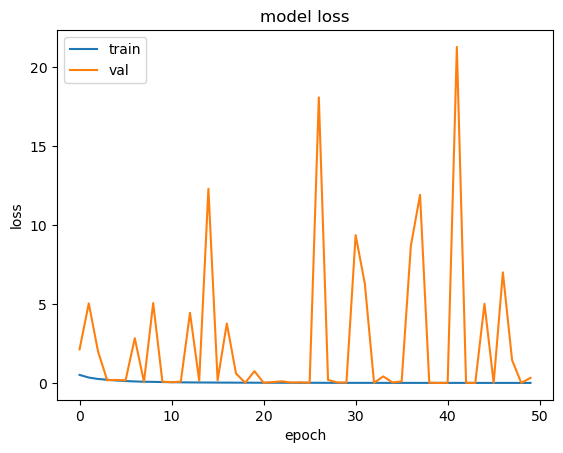

In [37]:
plot_history(h3)

In [38]:
pred1s = sm.predict([x_test[:,0], x_test[:,1]])

pred1_labels = []

31/31 [==============================] - 14s 282ms/step


In [39]:
pred11 = sm.predict([x_train[:, 0], x_train[:, 1]])

pred11_labels=[]

69/69 [==============================] - 19s 272ms/step


In [40]:
# threshold is 0.5
for p in pred1s:
    if p >= 0.5:
        pred1_labels.append(1)
    else:
        pred1_labels.append(0)
pred1_labels = np.array(pred1_labels)

In [41]:
# threshold is 0.5
for p in pred11:
    if p >= 0.5:
        pred11_labels.append(1)
    else:
        pred11_labels.append(0)
pred11_labels = np.array(pred11_labels)

In [42]:
print("Accuracy on test set: {}".format (accuracy_score( y_train,pred11_labels)))

Accuracy on test set: 0.8563611491108071


In [43]:
print ("Accuracy on test set: {}".format(accuracy_score(y_test, pred1_labels)))

Accuracy on test set: 0.8492307692307692


In [44]:
from sklearn import metrics
pred11_labels =  (sm.predict([x_train[:, 0], x_train[:, 1]])> 0.5).astype(int)
print('Precision : ', np.round(metrics.precision_score(y_test,pred1_labels )*100,2))
print('Accuracy : ', np.round(metrics.accuracy_score(y_test,pred1_labels)*100,2))
print('Recall : ', np.round(metrics.recall_score(y_test,pred1_labels)*100,2))
print('F1 score : ', np.round(metrics.f1_score(y_test,pred1_labels)*100,2))


69/69 [==============================] - 19s 274ms/step
Precision :  39.0
Accuracy :  84.92
Recall :  100.0
F1 score :  56.12


In [45]:
from sklearn.metrics import confusion_matrix
print("Confusion Matrix:")
print(confusion_matrix(y_train,pred11_labels))

Confusion Matrix:
[[1725  315]
 [   0  153]]


<AxesSubplot: >

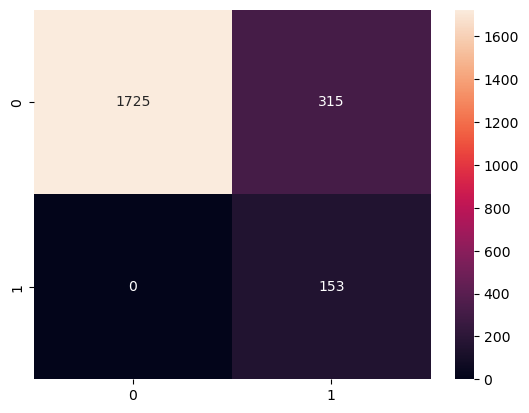

In [46]:
sns.heatmap(confusion_matrix(y_train,pred11_labels),fmt="d",annot=True)

In [47]:
from sklearn import metrics
pred1_labels = (sm.predict([x_test[:,0], x_test[:,1]]) > 0.5).astype(int)
print('Precision : ', np.round(metrics.precision_score(y_test,pred1_labels )*100,2))
print('Accuracy : ', np.round(metrics.accuracy_score(y_test,pred1_labels)*100,2))
print('Recall : ', np.round(metrics.recall_score(y_test,pred1_labels)*100,2))
print('F1 score : ', np.round(metrics.f1_score(y_test,pred1_labels)*100,2))


31/31 [==============================] - 10s 310ms/step
Precision :  39.0
Accuracy :  84.92
Recall :  100.0
F1 score :  56.12


In [48]:

from sklearn.metrics import confusion_matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, pred1_labels))

Confusion Matrix:
[[734 147]
 [  0  94]]


<AxesSubplot: >

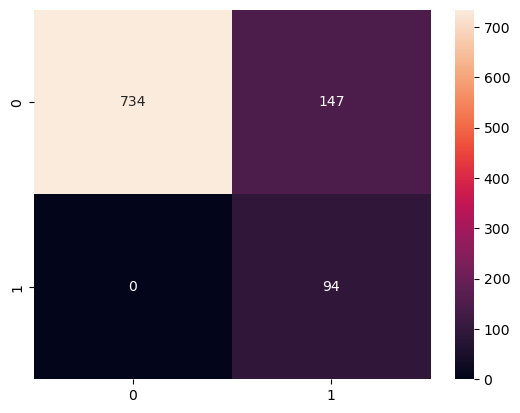

In [49]:
sns.heatmap(confusion_matrix(y_test,pred1_labels),fmt="d",annot=True)

In [52]:
# Save the trained model
sm.save('model1.h5')